#### 1. Load and process the requied matrices and packages

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd

import umap
import numpy as np
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import colorcet as cc
import datashader
%matplotlib inline

In [3]:
# set up some parameters for the plots
sns.set(style = 'white', context = 'poster', rc = {'figure.figsize':(10,6)})

#### 1.1 Load the original GTEx CPM data and single cell data of liver in Tabular
GTEx: https://gtexportal.org/home/datasets (raw counts matrix is converted to CPM)
Tabular: https://tabula-sapiens-portal.ds.czbiohub.org/organs

In [3]:
# load GTEx expression CPM matrix
GTEx_CPM = pd.read_csv("../../Universal_dataframe/GTEx_expression/GTEx_proc_CPM.csv", index_col= 0)

# load the single cell liver expression data
Tissue_i = sc.read_h5ad("../../Tabula/unzip_dataset_1/TS_Liver.h5ad") # here, the tissue_i is liver

#### 1.2 Plot the zero-proportion of the single cell data

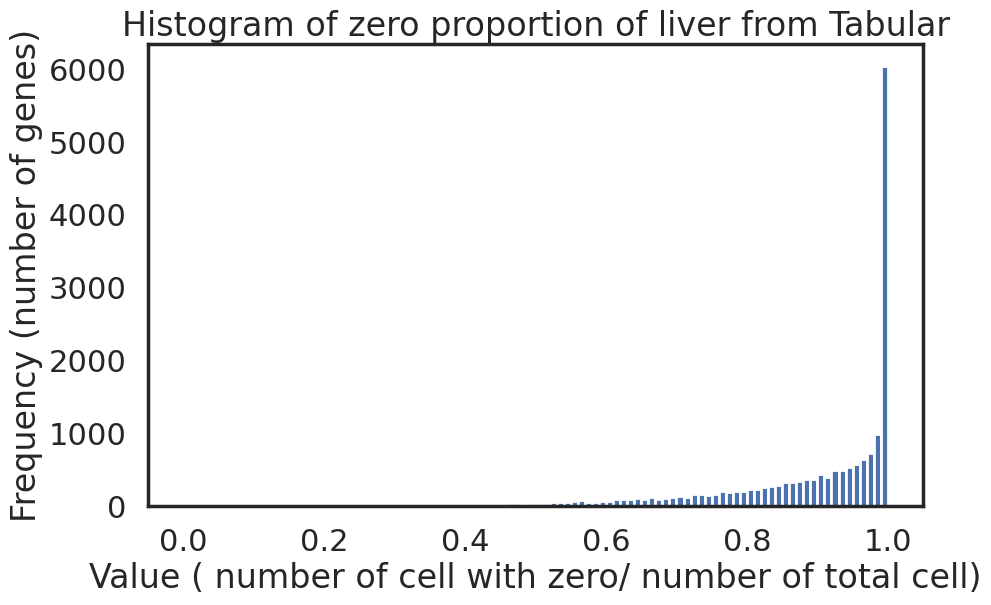

In [4]:
the_tissue = "liver"
Tissue_i_X = pd.DataFrame(Tissue_i.layers["raw_counts"].todense())
Tissue_i_X.columns = Tissue_i.var["gene_symbol"]

# filter by the protein_coding gene in GTEx
GTEx_columns = GTEx_CPM.columns.to_list()
GTEx_columns.remove("Tissue")
filter0 = GTEx_columns
filter = list(set(Tissue_i_X.columns.to_list()).intersection(set(filter0)))

Tissue_i_X = Tissue_i_X[filter]

Tissue_i_X.index = Tissue_i.obs['donor'].index
Tissue_i_X["donor"] = Tissue_i.obs["donor"]

# remove the duplicates of the data
Tissue_i_X = Tissue_i_X.loc[:,~Tissue_i_X.columns.duplicated()] #remove column duplicates
Tissue_i_X = Tissue_i_X.drop_duplicates() # remove row duplicates

# get the zero proportion of genes in liver
Tissue_i_zero = Tissue_i_X == 0

# record the zero-proportion of each gene
Zero_proportion = []

for i in range(len(Tissue_i_zero.iloc[1, :])):
    proportion = Tissue_i_zero.iloc[:, i].sum()/len(Tissue_i_zero.iloc[:, 0])

    Zero_proportion.append(proportion)

def plot_histogram(lst):
    plt.hist(lst, bins=100)
    plt.xlabel('Value ( number of cell with zero/ number of total cell)')
    plt.ylabel('Frequency (number of genes)')
    plt.title('Histogram of zero proportion of {} from Tabular'.format(the_tissue))
    plt.show()

plot_histogram(Zero_proportion)

As we can see, majority of the cells has a pretty large zero-proportion(>0.9).

#### 1.3 Select gene lists with various zero-proportion thresholds and combine the GTEx data and pseudobulk data

The thresholds selected here are 0.99, 0.9, 0.8, 0.7.

In [5]:
# select genes with different zero-proportions
Zero_p = pd.DataFrame()
Zero_p["gene"] = Tissue_i_X.columns.to_list()
Zero_p["Zero_proportion"] = Zero_proportion
Zero_p = Zero_p.iloc[:-1, :]

In [6]:
# filter the original gene lists by certain number of zero-proportion as the threshold in GTEx data and single cell data
prop = [0.99, 0.9, 0.8, 0.7]
merged_data = []

for p in prop:

    GTEx_CPM_filtered = GTEx_CPM[["Tissue"] + Zero_p.gene[Zero_p["Zero_proportion"] <= p].to_list()]
    Tissue_i_X_filtered = Tissue_i_X[["donor"] + Zero_p.gene[Zero_p["Zero_proportion"] <= p].to_list()]


    # sum the cells by donors to make the pseudobulk
    Tissue_i_f_pseudo = Tissue_i_X_filtered.groupby("donor").sum()
    Tissue_i_f_pseudo.reset_index(inplace=True)

    # convert the counts to CPM for single cell data
    # for each gene and sample
    total_counts = Tissue_i_f_pseudo.iloc[:, 1:].sum(axis=1)
    cpm_scaling_factor = 1e6 / total_counts.values

    # create a copy of GTEx_counts_proc to store CPM values
    Tissue_i_f_CPM = Tissue_i_f_pseudo.copy()
    # normalize raw counts to CPM using numpy broadcasting
    Tissue_i_f_CPM.iloc[:, 1:] = Tissue_i_f_pseudo.iloc[:, 1:].values * cpm_scaling_factor.reshape(-1, 1)

    Tissue_i_f_CPM = Tissue_i_f_CPM.rename(columns = {"donor" : "Tissue"})
    Tissue_i_f_CPM.Tissue = the_tissue

    merged = pd.concat([GTEx_CPM_filtered, Tissue_i_f_CPM])
    merged.reset_index(inplace=True, drop= True)

    merged_data.append(merged)


In [23]:
# save the results
ratio = [99, 90, 80, 70]
i = 0
for matrix_i in merged_data:
    matrix_i.to_csv("GTEx_liver_CPM_merge/merged_CPM_{}.csv".format(ratio[i]))
    i += 1

This is an example of merged data(CPM) with zero-proportion = 0.90.

In [12]:
merged_data[1]

Tissue      POLR2C      LILRB5       YLPM1       ING5        GOT1  \
0      ADPSBQ   72.097167   81.779825  123.715283  44.117466   28.411557   
1      MSCLSK  122.116655    5.007360  130.165134  58.829922  207.530151   
2      ARTTBL   92.923865    8.536908  102.165887  63.787575   18.660321   
3      ARTCRN   61.280913   36.213375   85.564429  75.308564   16.909464   
4       HRTAA   52.494796   16.168765   80.015446  58.968438  245.875684   
...       ...         ...         ...         ...        ...         ...   
17379  ARTTBL   75.353499    5.935865   87.811707  51.556722   16.599096   
17380  MSCLSK   74.287329   13.233528   95.328248  25.100763  191.515310   
17381  ADPSBQ   56.746888  125.804483   94.409136  47.133583   21.437262   
17382   liver   70.578011   13.602497   56.273918  14.021358  251.358231   
17383   liver   26.274071   14.855628   38.974174  32.332836  132.011185   

            LAMB1        IPO7     COMMD1    ARHGAP17  ...     LAPTM4A  \
0      520.158784   69.437845  14.092132  102.690731  ...  402.262187   
1       96.765259  183.830397  12.924756   40.714291  ...  101.169638   
2      250.441149  124.805061   9.242021   84.538053  ...  317.955752   
3      604.354403  163.373390  14.748104   96.519558  ...  321.301000   
4      758.275209  151.624361  18.807311   67.374969  ...  305.181611   
...           ...         ...        ...         ...  ...         ...   
17379  146.050720  250.674787  17.469927  126.394831  ...  307.101051   
17380  107.234520  492.021802  13.174973   48.932825  ...  110.494106   
17381  568.908843  146.815839  15.434018  110.390747  ...  448.478886   
17382   18.995327   39.603268  81.164711   44.723839  ...  265.840332   
17383   68.918465   72.064362  36.236080   19.166672  ...  144.478256   

           PDCD5       USP36     MRPS30       CYTH1        CD37       ROCK2  \
0      64.005555  136.443661  27.252365   85.484692   15.319511  138.557481   
1      80.799384  109.873530  27.632236   61.005895    2.805170  124.004247   
2      92.042474  174.868109  24.225680   50.516334   25.132254  178.242580   
3      75.986638   90.798311  22.122155   52.593094   13.730993  142.628571   
4      73.511123   90.262823  31.969361   58.968438   29.269454   72.253211   
...          ...         ...        ...         ...         ...         ...   
17379  59.483057   67.675972  24.294394   21.770763   12.404892  221.102093   
17380  54.144259   51.489746  49.459824   56.193699    2.322699  109.928070   
17381  52.731204   71.572468  26.750945   87.087611   16.671173  244.672785   
17382  41.708042  312.553772  72.305809  157.784775  193.387924  122.987938   
17383  84.298409   36.935169  26.390585   38.042057   19.399702   92.862236   

          ZNF672     MAD2L2     ZMYND11  
0      35.434894  41.980916  116.464654  
1      34.920435  35.497199   92.124931  
2      44.296227  29.085925  137.245275  
3      27.906972  19.282722  130.232536  
4      40.437254  19.758415  107.750861  
...          ...        ...         ...  
17379  22.943719  12.244944  222.008468  
17380  75.985436  19.537997  131.632618  
17381  24.702541  17.340453  145.436716  
17382  15.466427  57.499084   82.358459  
17383  14.098282  31.808521   40.022808  

[17384 rows x 6987 columns]

#### 2. PCA analysis of the merged data

##### 2.1 Do the analysis for the matrix with zero-proportion = 0.99 first, and take a look at the result. 

In [2]:
merged_i = pd.read_csv("GTEx_liver_CPM_merge/merged_CPM_99.csv", index_col= 0)

In [15]:
merged_i = merged_data[0]

# remove columns with all zeros
all_zeros = (merged_i == 0).all()
merged_i0 = merged_i.drop(columns = merged_i.columns[all_zeros])

print(f"Check: it's {merged_i0.shape == merged_i.shape} that no column in the matrix with all zeros") # the output is True so there is no column with all zeros.

Check: it's True that no column in the matrix with all zeros


In [3]:
# Run PCA and remove some top PCs

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
# Standardizing the features
x = merged_i.copy().iloc[:, 1:]
x_standard = StandardScaler().fit_transform(x)

# SVD method
u, s, vh = np.linalg.svd(x_standard, full_matrices=True)


# check the SVD result
smat = np.zeros((len(u), len(vh)))
smat[:len(s), :len(s)] = np.diag(s)
old_matrix = np.dot(u, np.dot(smat, vh))

print(f"Check SVD for top PCs removing: {np.allclose(x_standard, old_matrix)}")

Check SVD for top PCs removing: True


Plot the PCA explained variance ratio

Text(0.5, 1.0, 'PCA explained variance ratio')

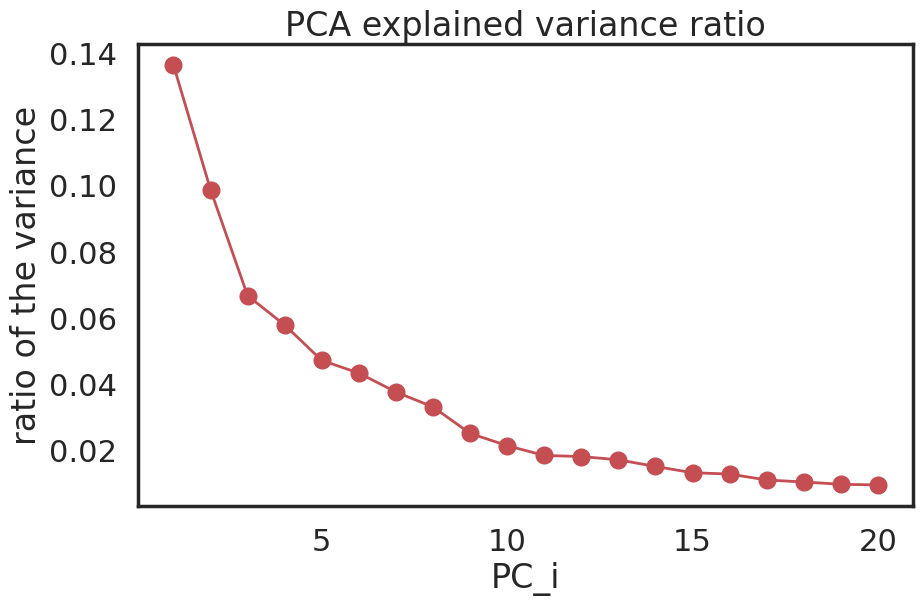

In [21]:
# PCA
pca = PCA()
ppc = pca.fit_transform(x_standard)

plt.plot(np.arange(1,21,1), pca.explained_variance_ratio_[0:20], 'ro-', linewidth=2)
plt.xlabel('PC_i')
plt.ylabel('ratio of the variance')
plt.title('PCA explained variance ratio')

Plot the PCs' correlations with indicator vector (GTEx or single cell data)

In [36]:
label_vector = np.array([0]*(len(ppc)-2) + [1]*(len(ppc)- 17382))

corr = []
for i in range(len(ppc[0])):
    correlation = abs(np.corrcoef(label_vector, ppc[:,i])[1][0])
    corr.append(correlation)


Text(0.5, 1.0, 'correlation with PCi and indicator vector(0/1: sc or GTEx)')

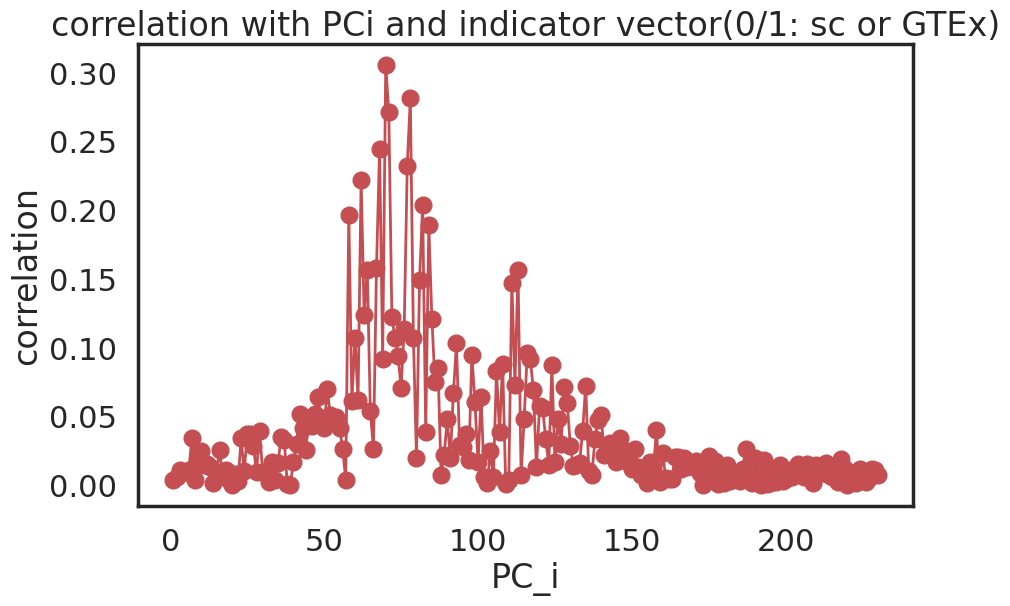

In [43]:
plt.plot(np.arange(1, 231 , 1), corr[0:230], 'ro-', linewidth=2)
plt.xlabel('PC_i')
plt.ylabel('correlation')
plt.title('correlation with PCi and indicator vector(0/1: sc or GTEx)')

#### 2.1.1 Remove the some PCs iteratively and plot the PC_i vs. PC_i+1

Remove 0 PCs:

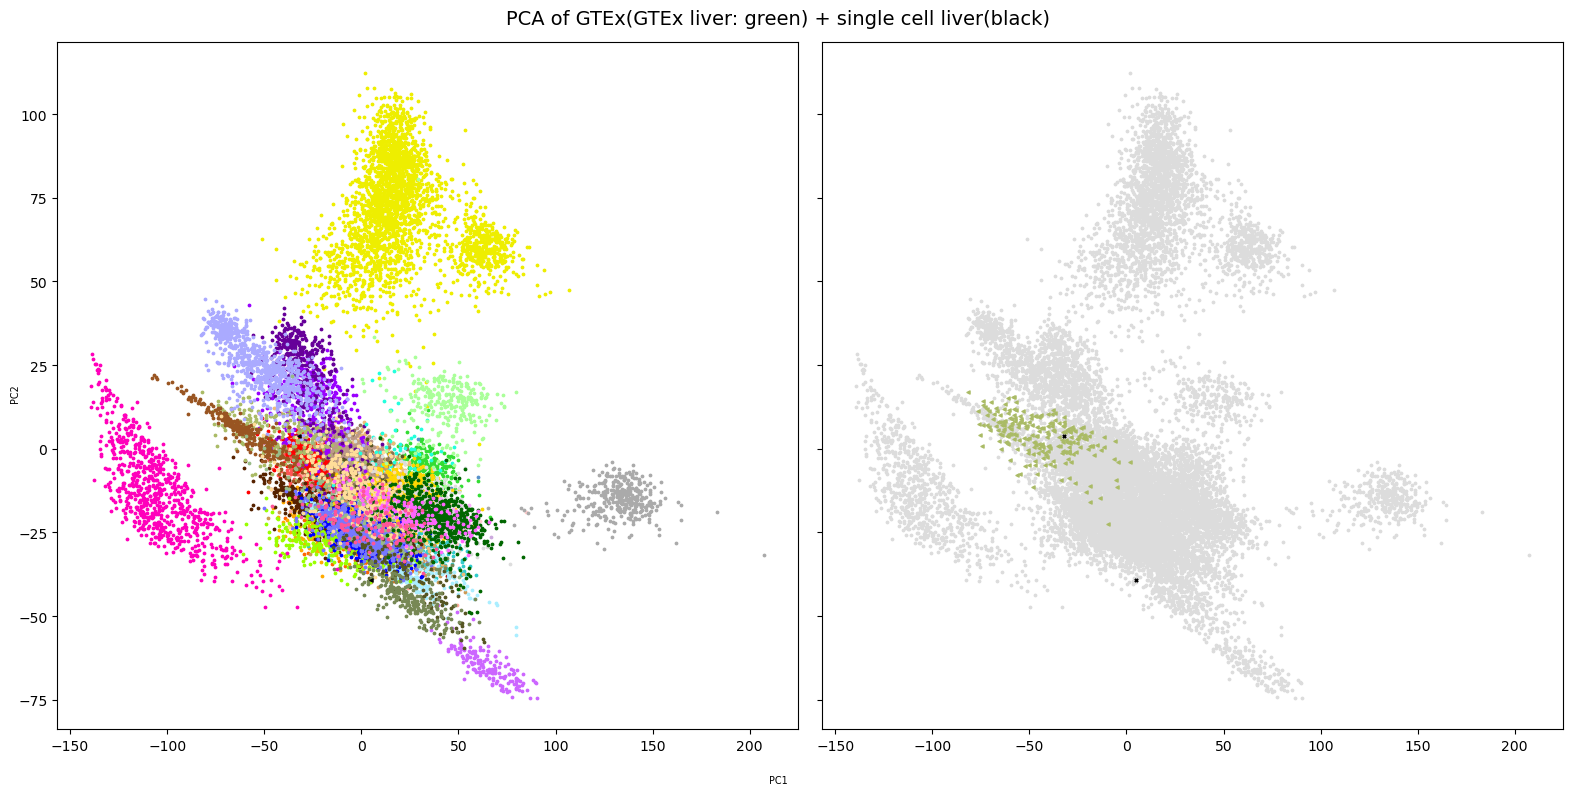

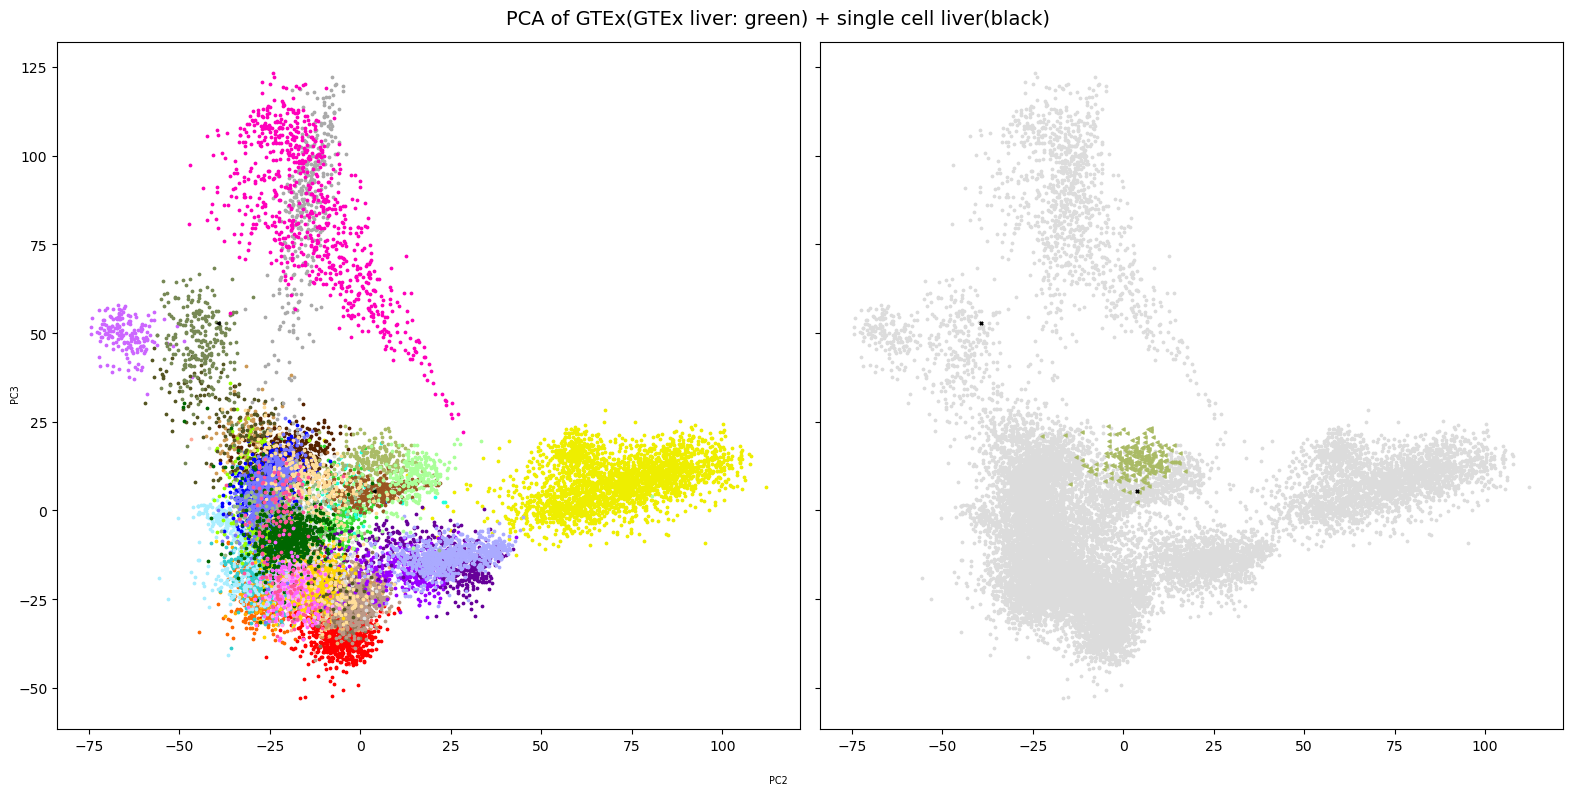

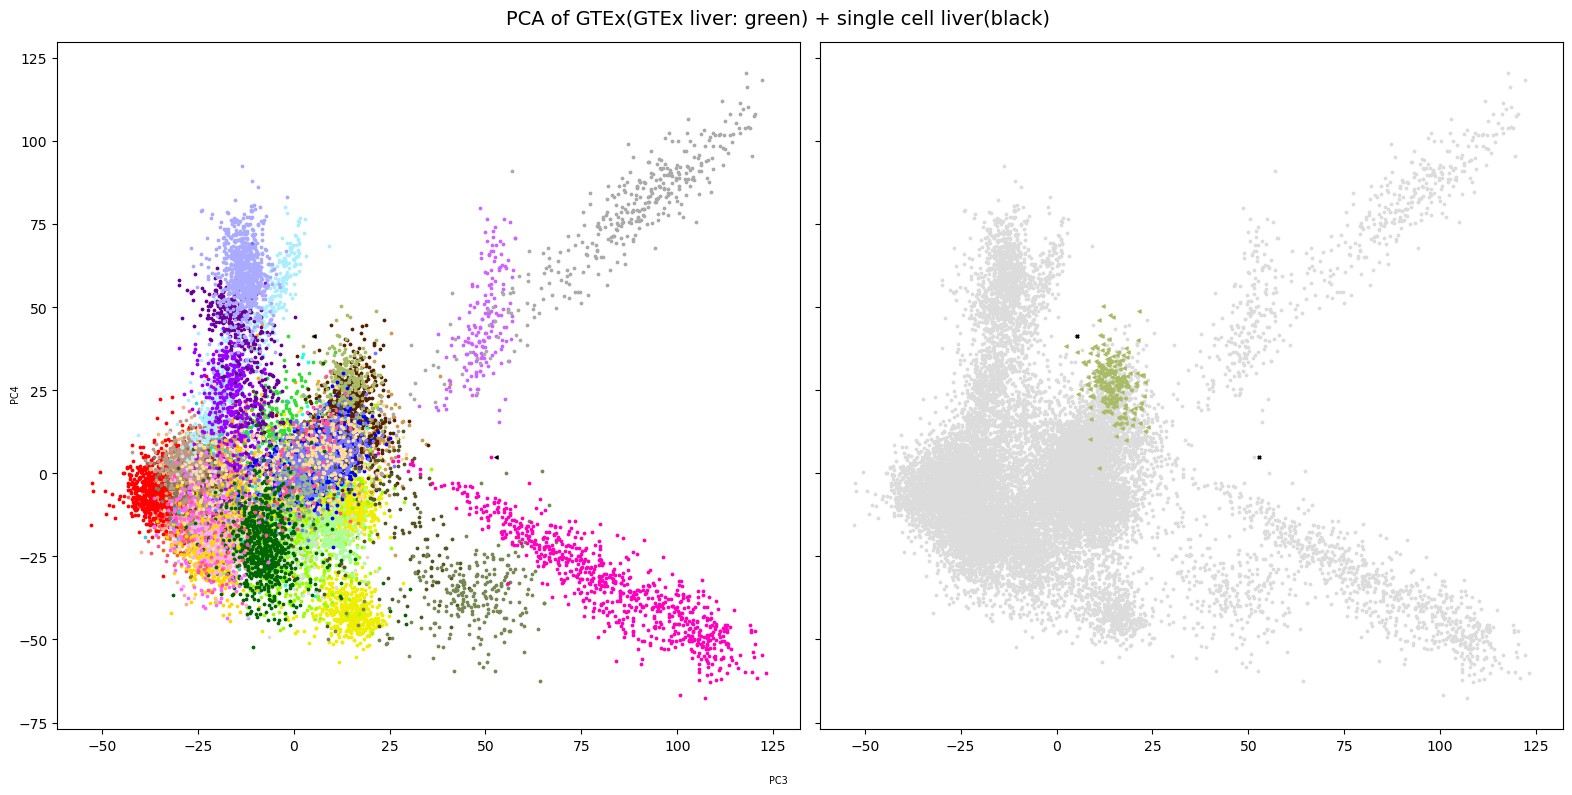

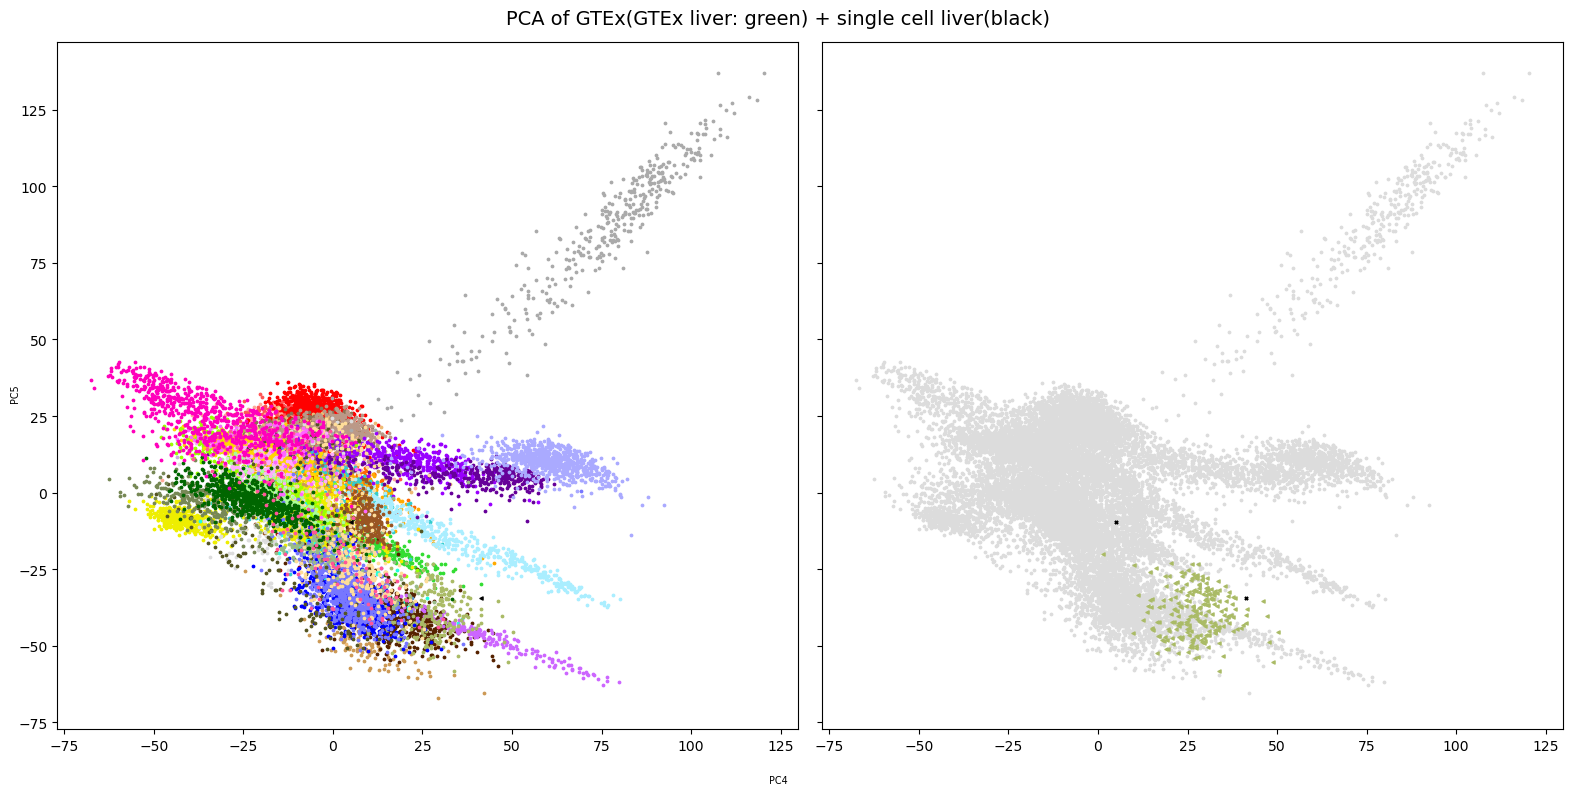

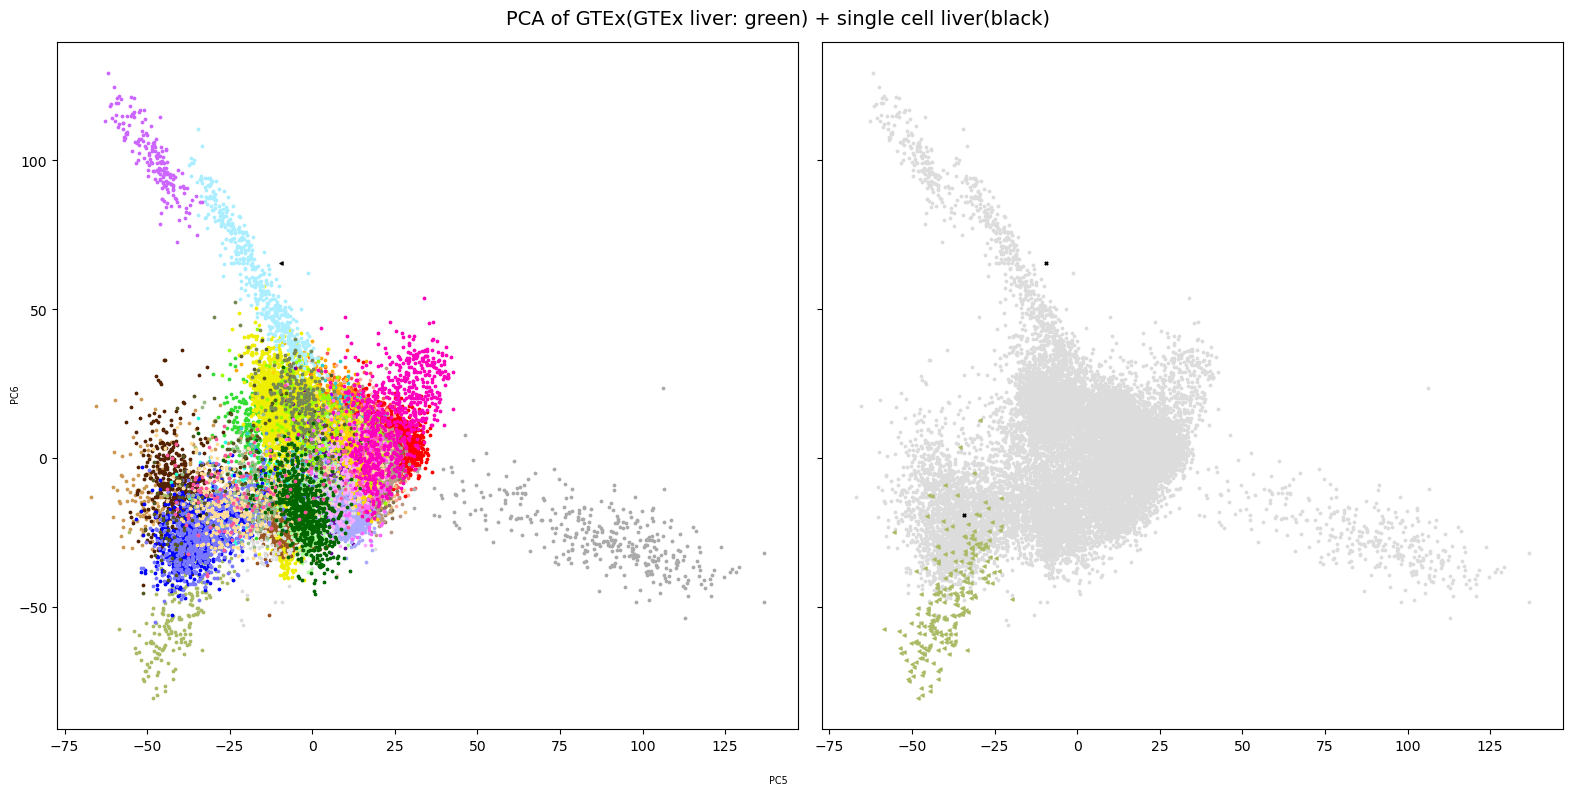

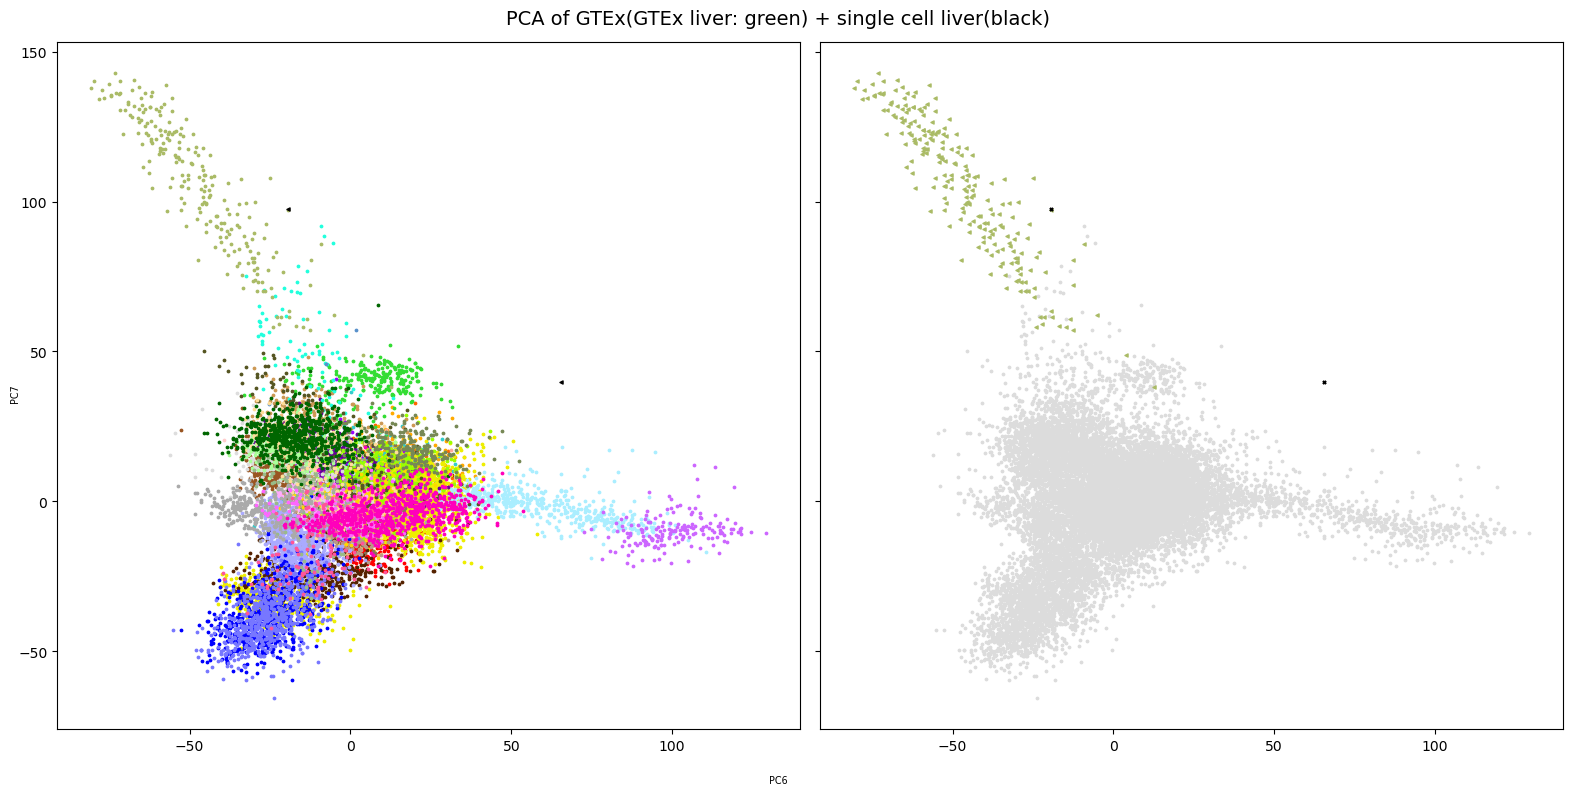

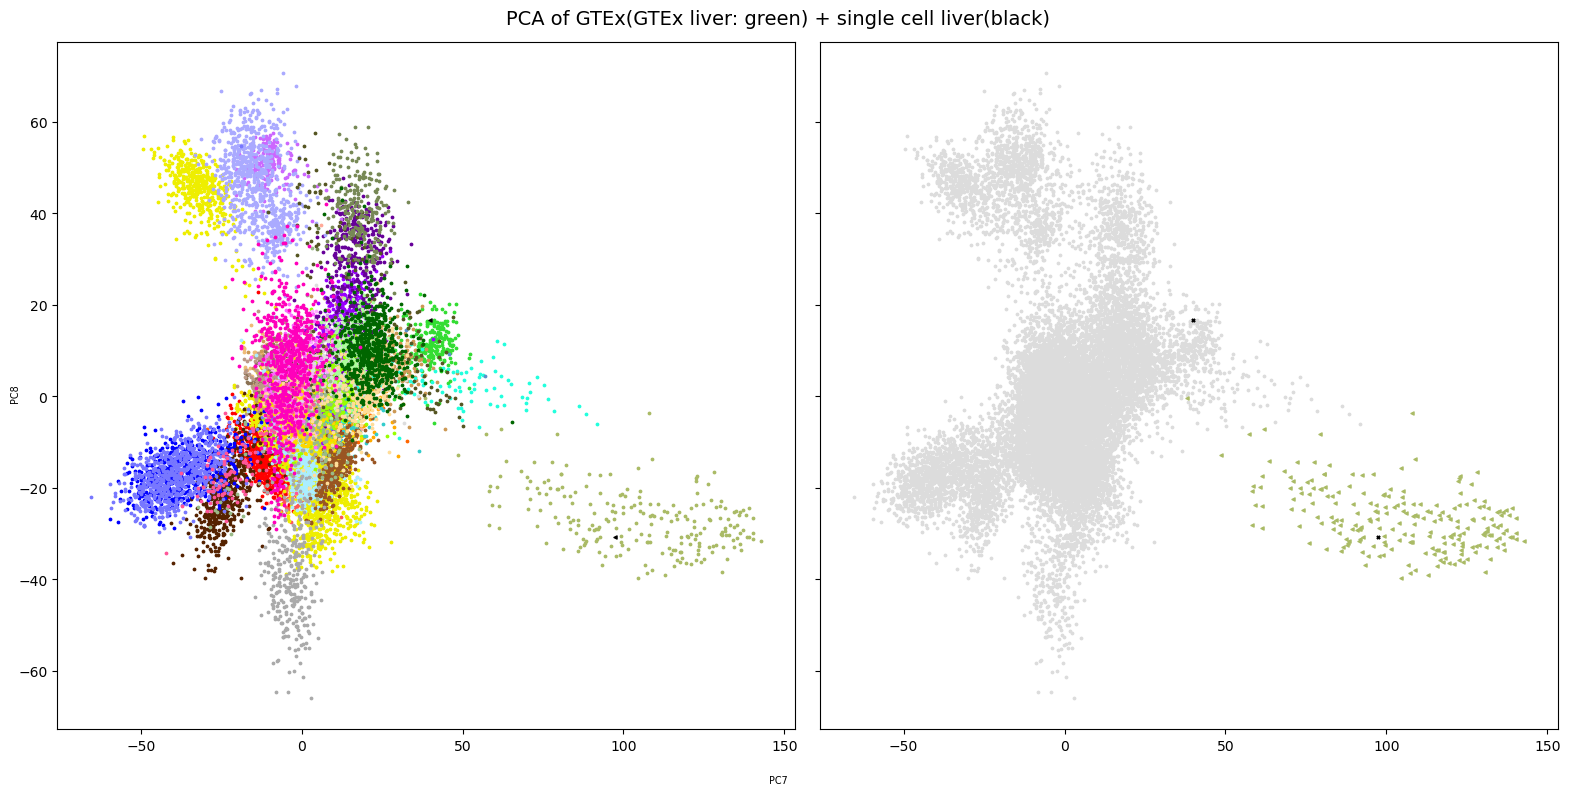

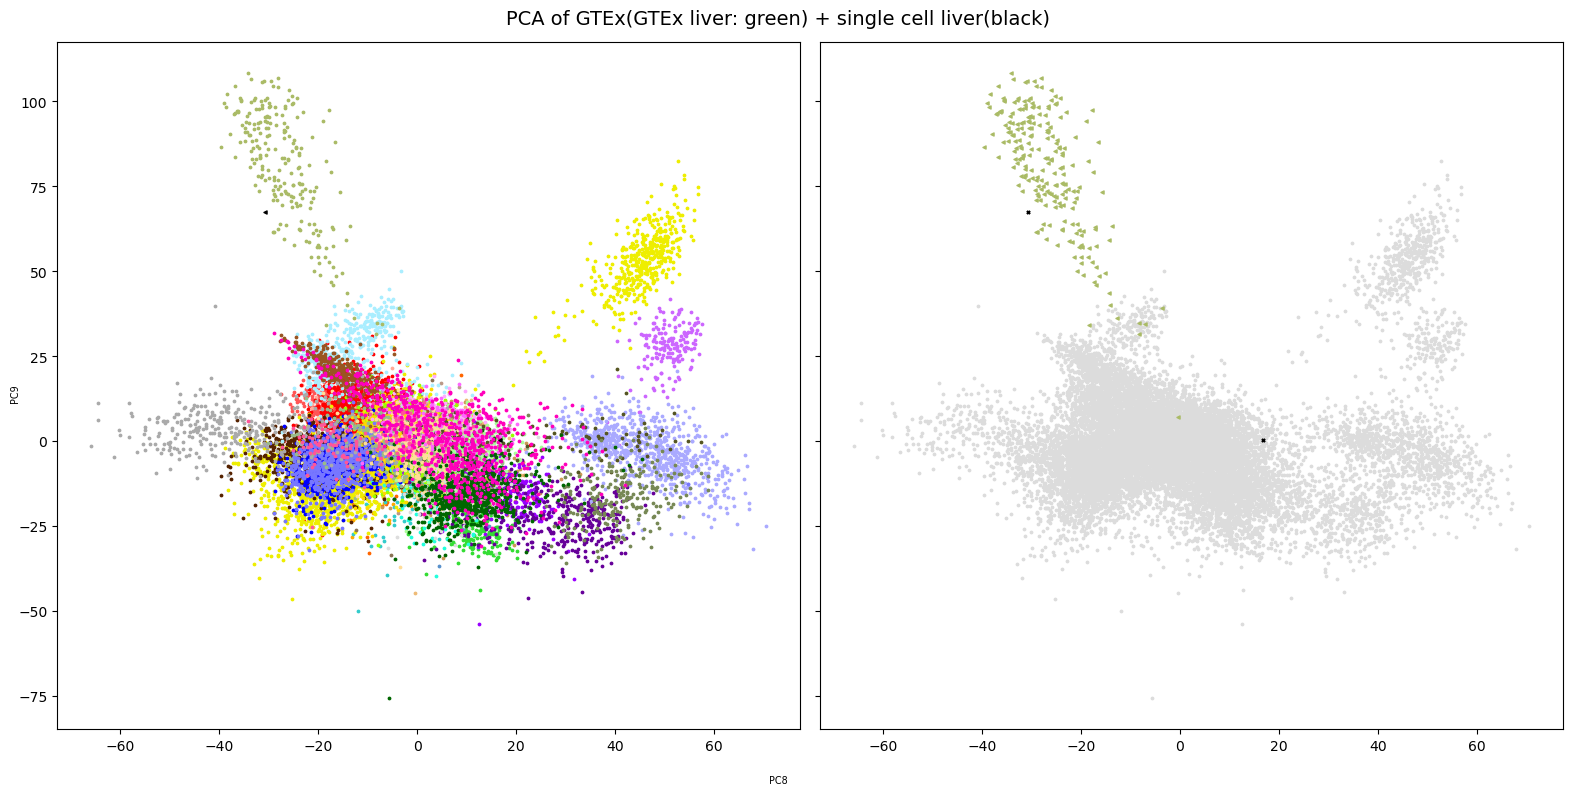

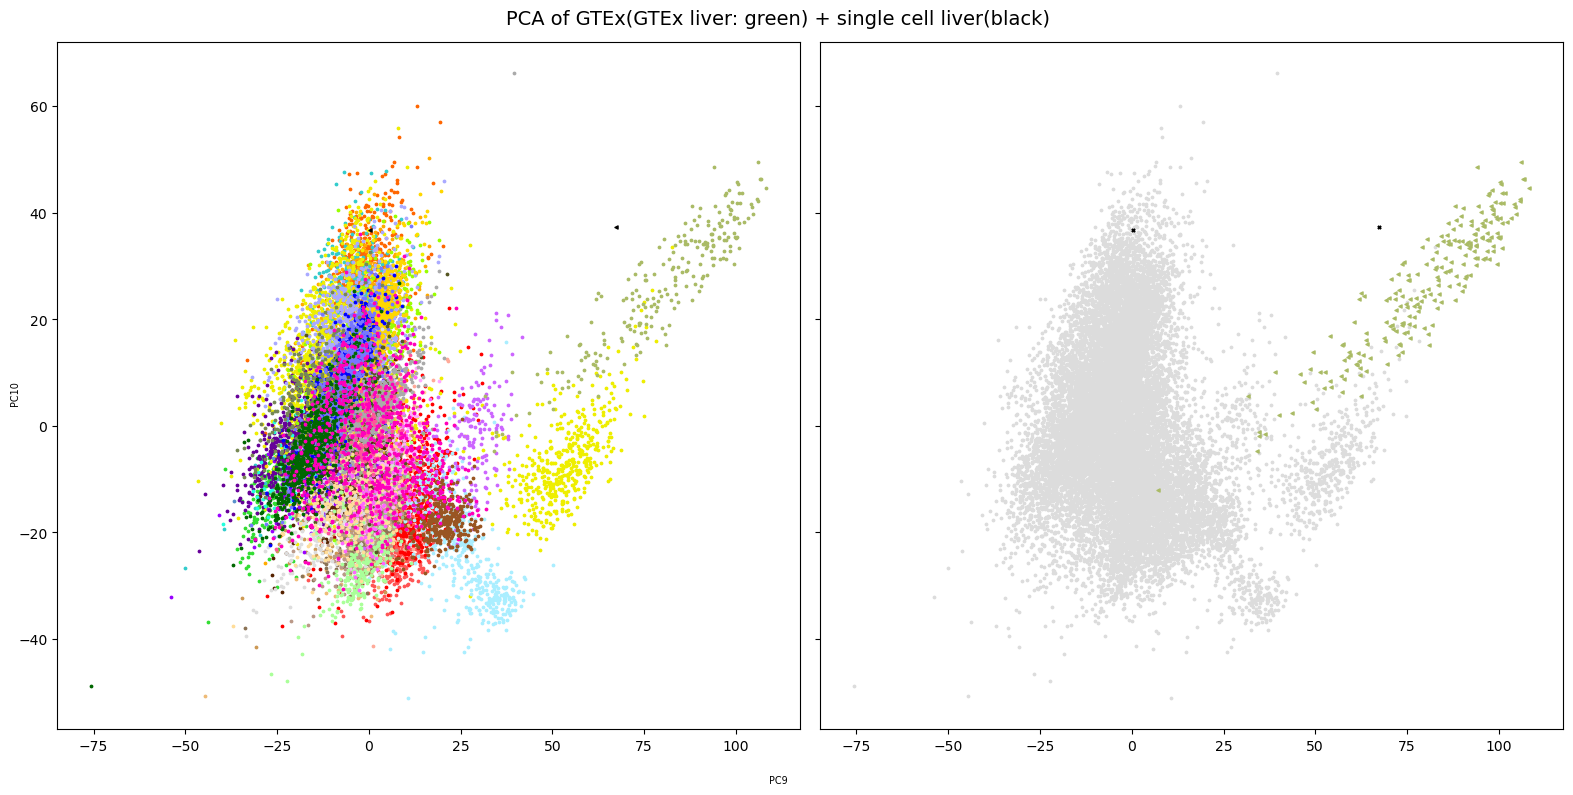

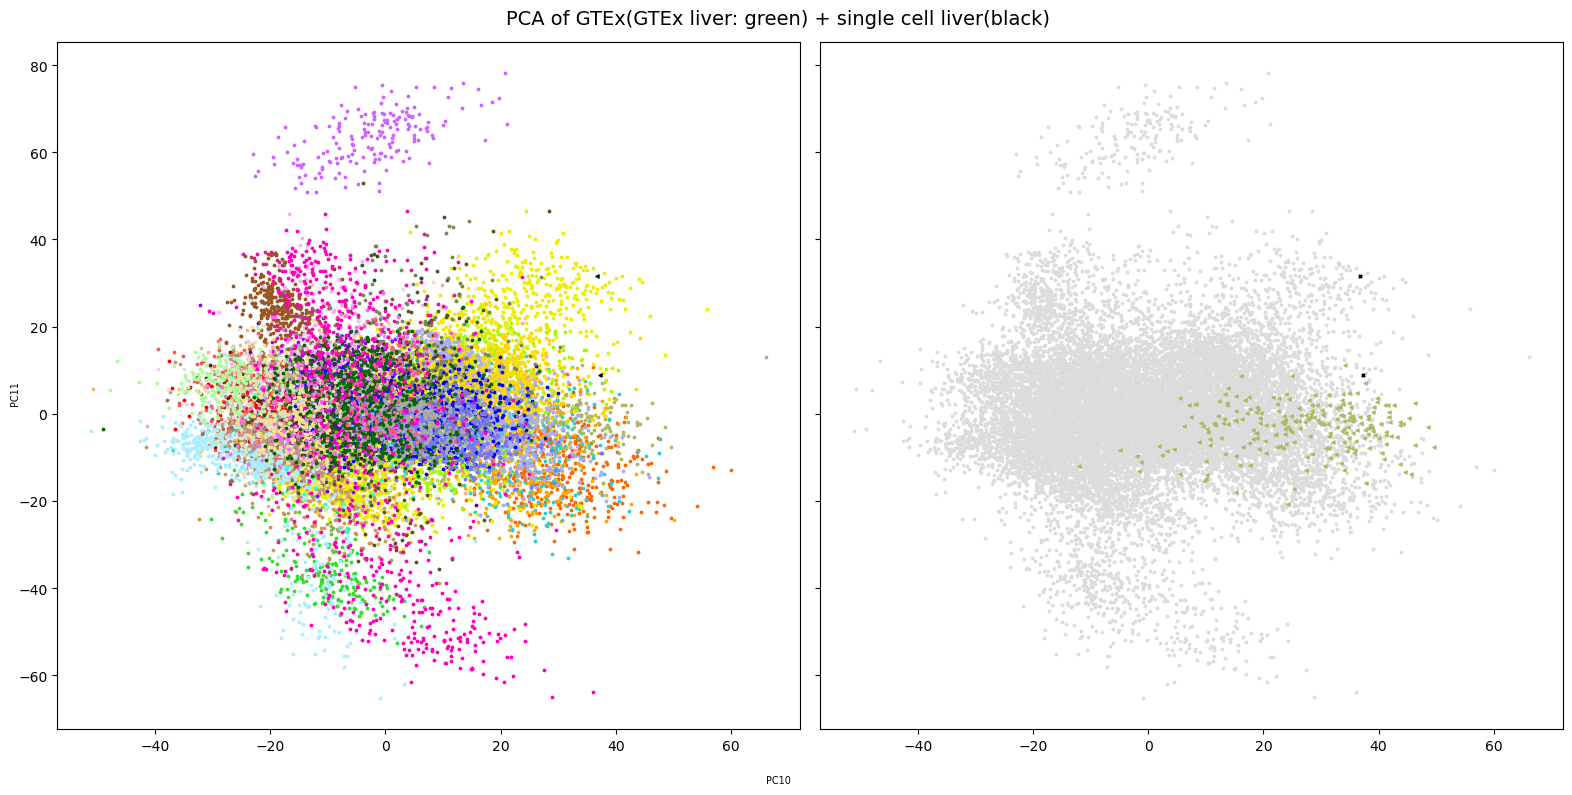

In [7]:

# make the plot of PCA result

for j in range(10):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

    scatter_x = np.array(ppc[:,j])
    scatter_y = np.array(ppc[:,j+1])
    group = np.array(merged_i.Tissue.tolist())
    cdict = {"Kidney - Medulla" : [89, 145, 203], "ADPSBQ":[255,102,0],"ADPVSC":[255,170,0],"ADRNLG":[51,221,51],"ARTAORT":[255,85,85],"ARTCRN":[255,170,153],"ARTTBL":[255,0,0],"BLDDER":[170,0,0],"BRNAMY":[238,238,0],"BRNACC":[238,238,0],"BRNCDT":[238,238,0],"BRNCHB":[238,238,0],"BRNCHA":[238,238,0],"BRNCTXA":[238,238,0],"BRNCTXB":[238,238,0],"BRNHPP":[238,238,0],"BRNHPT":[238,238,0],"BRNNCC":[238,238,0],"BRNPTM":[238,238,0],"BRNSPC":[238,238,0],"BRNSNG":[238,238,0],"BREAST":[51,204,204],"LCL":[204,102,255],"FIBRBLS":[170,238,255],"CVXECT":[255,204,204],"CVSEND":[204,170,221],"CLNSGM":[238,187,119],"CLNTRN":[204,153,85],"EESPGEJ":[139,115,85],"ESPMCS":[85,34,0],"ESPMSL":[187,153,136],"FLLPNT":[255,204,204],"HRTAA":[153,0,255],"HRTLV":[102,0,153],"KDNCTX":[34,255,221],"LIVER":[170,187,102],"LUNG":[153,255,0],"SLVRYG":[153,187,136],"MSCLSK":[170,170,255],"NERVET":[255,215,0],"OVARY":[255,170,255],"PNCREAS":[153, 85, 34],"PTTARY":[170,255,153],"PRSTTE":[221,221,221],"SKINNS":[0,0,255],"SKINS":[119,119,255],"SNTTRM":[85,85,34],"SPLEEN":[119,136,85],"STMACH":[255,221,153],"TESTIS":[170,170,170],"THYROID":[0,102,0],"UTERUS":[255,102,255],"VAGINA":[255,85,153],"WHLBLD":[255,0,187], "macrophage": [0,0,0], "monocyte":[0,0,0], "endothelial cell of hepatic sinusoid":[0,0,0], "liver dendritic cell":[0,0,0], "nk cell":[0,0,0], "fibroblast":[0,0,0], "hepatocyte":[0,0,0], "intrahepatic cholangiocyte":[0,0,0], "t cell":[0,0,0], "neutrophil":[0,0,0], "plasma cell":[0,0,0], "erythrocyte":[0,0,0], "endothelial cell":[0,0,0], "liver":[0, 0, 0]}


    for g in np.unique(group):
        if g != "liver":
            ix = np.where(group == g)
            ax[0].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, s = 3, zorder = 0)
        else:
            ix = np.where(group == g)
            ax[0].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, marker = "<", s = 5, zorder = 1)

    # ax[0].legend()




    for i in range(len(np.unique(group))):
        
        g = np.unique(group)[i]
        if (g!= "liver") and (g!= "LIVER"):
            ix = np.where(group == g)
            ax[1].scatter(scatter_x[ix], scatter_y[ix], color = np.array([220, 220, 220])/255.0, s = 3, zorder = 0)
        elif(g == "LIVER"):
            ix = np.where(group == g)
            ax[1].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, marker = "<", s = 5, zorder = 1)
        elif(g == "liver"):
            ix = np.where(group == g)
            ax[1].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, marker = "x", s = 5, zorder = 1)

    # ax[1].legend()

    fig.supxlabel("PC{}".format(j+1), fontsize = 'x-small')
    fig.supylabel("PC{}".format(j+2), fontsize = 'x-small')
    # plt.legend(loc = 0, fontsize = 'xx-small')
    fig.suptitle('PCA of GTEx(GTEx liver: green) + single cell liver(black)', fontsize=14)
    

    #plt.savefig("Figures/Umap/TS_Liver_normalized_cta_1.jpg")
    plt.tight_layout()
    plt.show()

Remove some PCs that are highly related to indicator vector with certain threshold and see the result of PCA again.

(to be done)

#### 2.2 Same analysis for matrix with genes having lower zero-proportion (0.7)

In [79]:
merged_i = merged_data[3]

# Standardizing the features
x = merged_i.copy().iloc[:, 1:]
x_standard = StandardScaler().fit_transform(x)

Plot the PCA explained variance ratio.

Text(0.5, 1.0, 'PCA explained variance ratio')

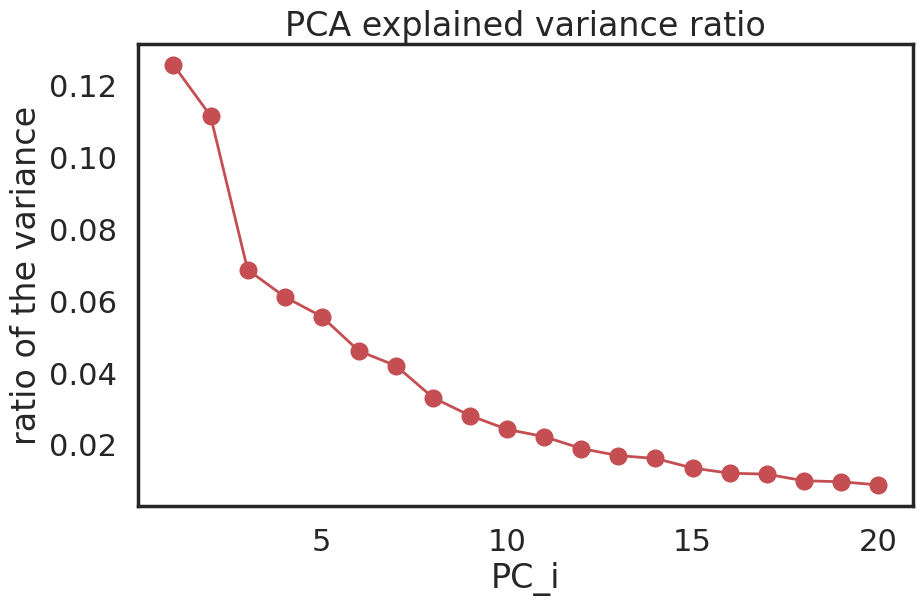

In [80]:
# PCA
pca = PCA()
ppc = pca.fit_transform(x_standard)

plt.plot(np.arange(1,21,1), pca.explained_variance_ratio_[0:20], 'ro-', linewidth=2)
plt.xlabel('PC_i')
plt.ylabel('ratio of the variance')
plt.title('PCA explained variance ratio')

Plot the PCs' correlations with indicator vector (GTEx or single cell data).

Text(0.5, 1.0, 'correlation with PCi and indicator vector(0/1: sc or GTEx)')

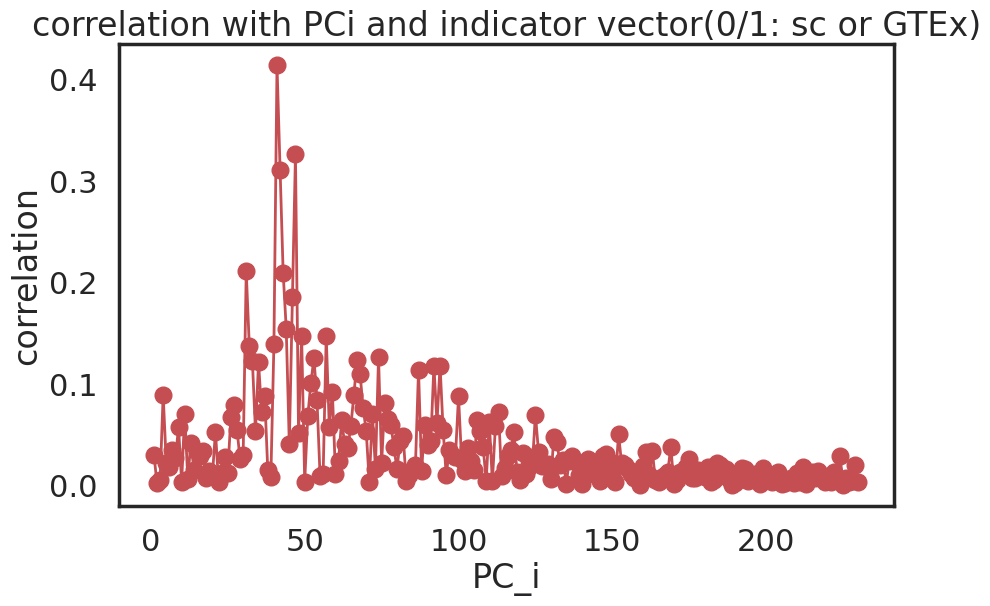

In [81]:
label_vector = np.array([0]*(len(ppc)-2) + [1]*(len(ppc)- 17382))

corr = []
for i in range(len(ppc[0])):
    correlation = abs(np.corrcoef(label_vector, ppc[:,i])[1][0])
    corr.append(correlation)

plt.plot(np.arange(1, 231 , 1), corr[0:230], 'ro-', linewidth=2)
plt.xlabel('PC_i')
plt.ylabel('correlation')
plt.title('correlation with PCi and indicator vector(0/1: sc or GTEx)')

#### 2.1.1 Remove the some PCs iteratively and plot the PC_i vs. PC_i+1

Remove 0 PCs

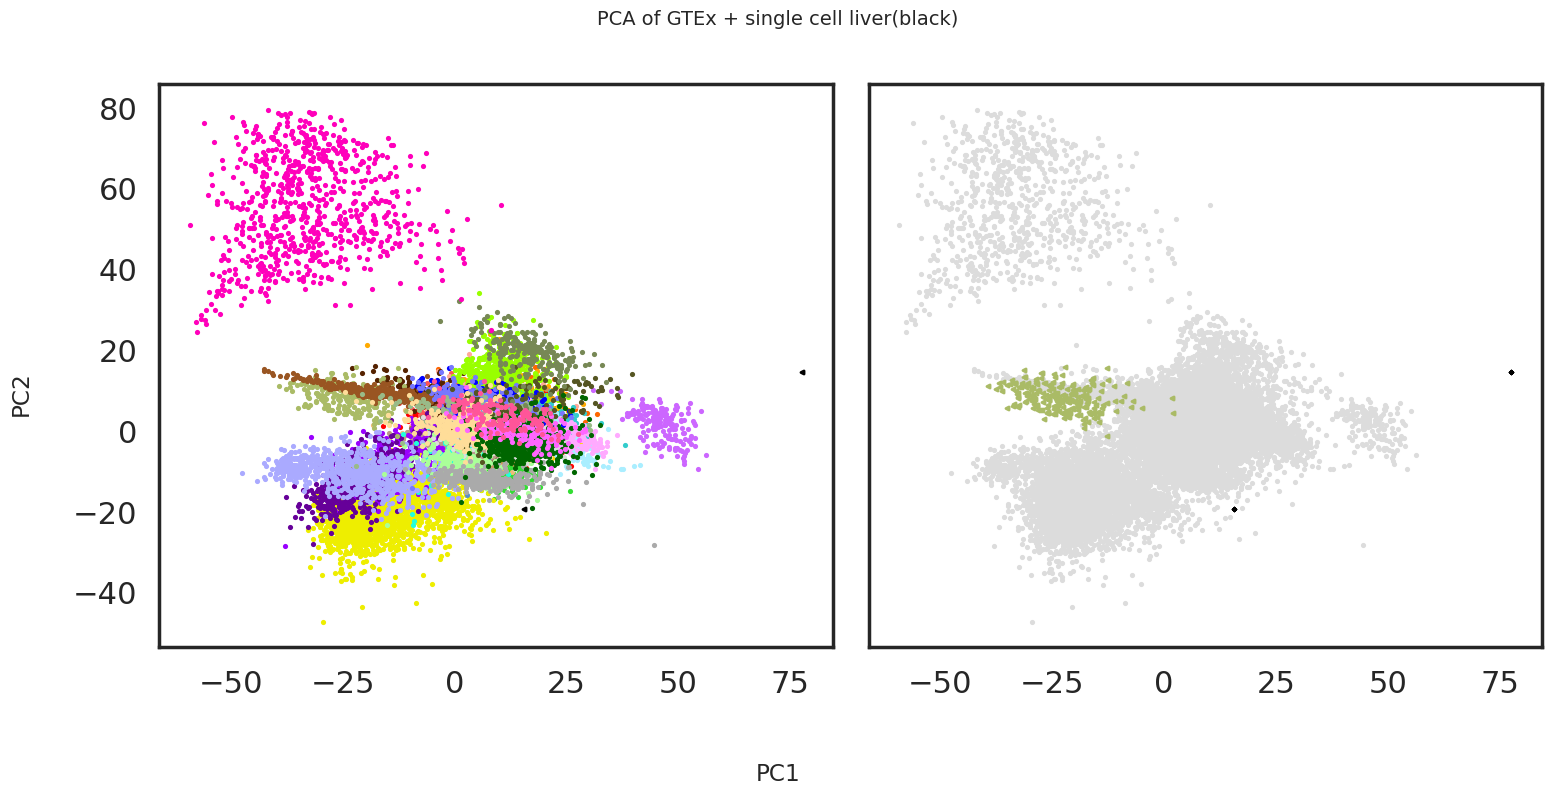

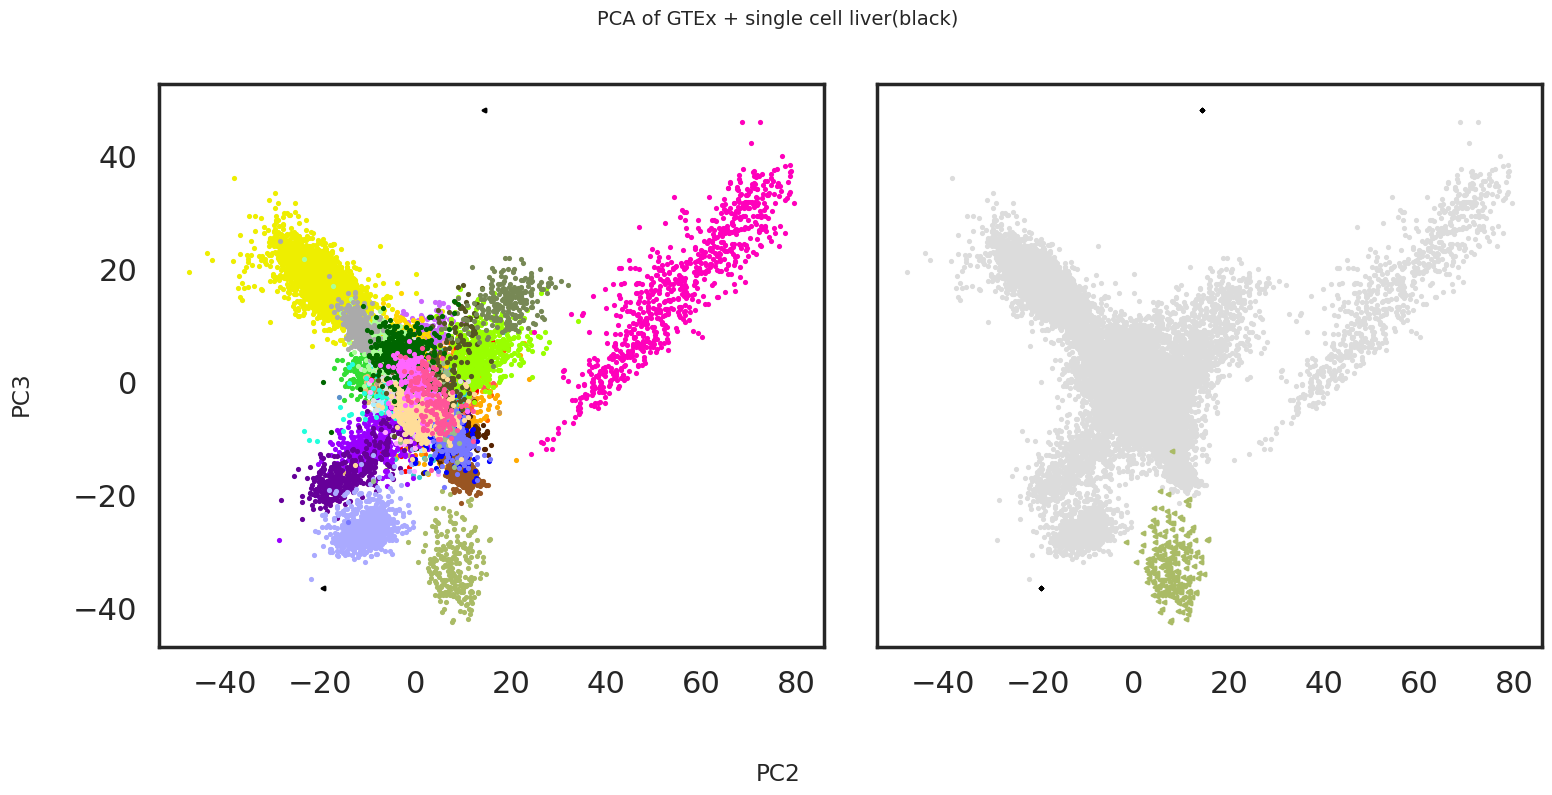

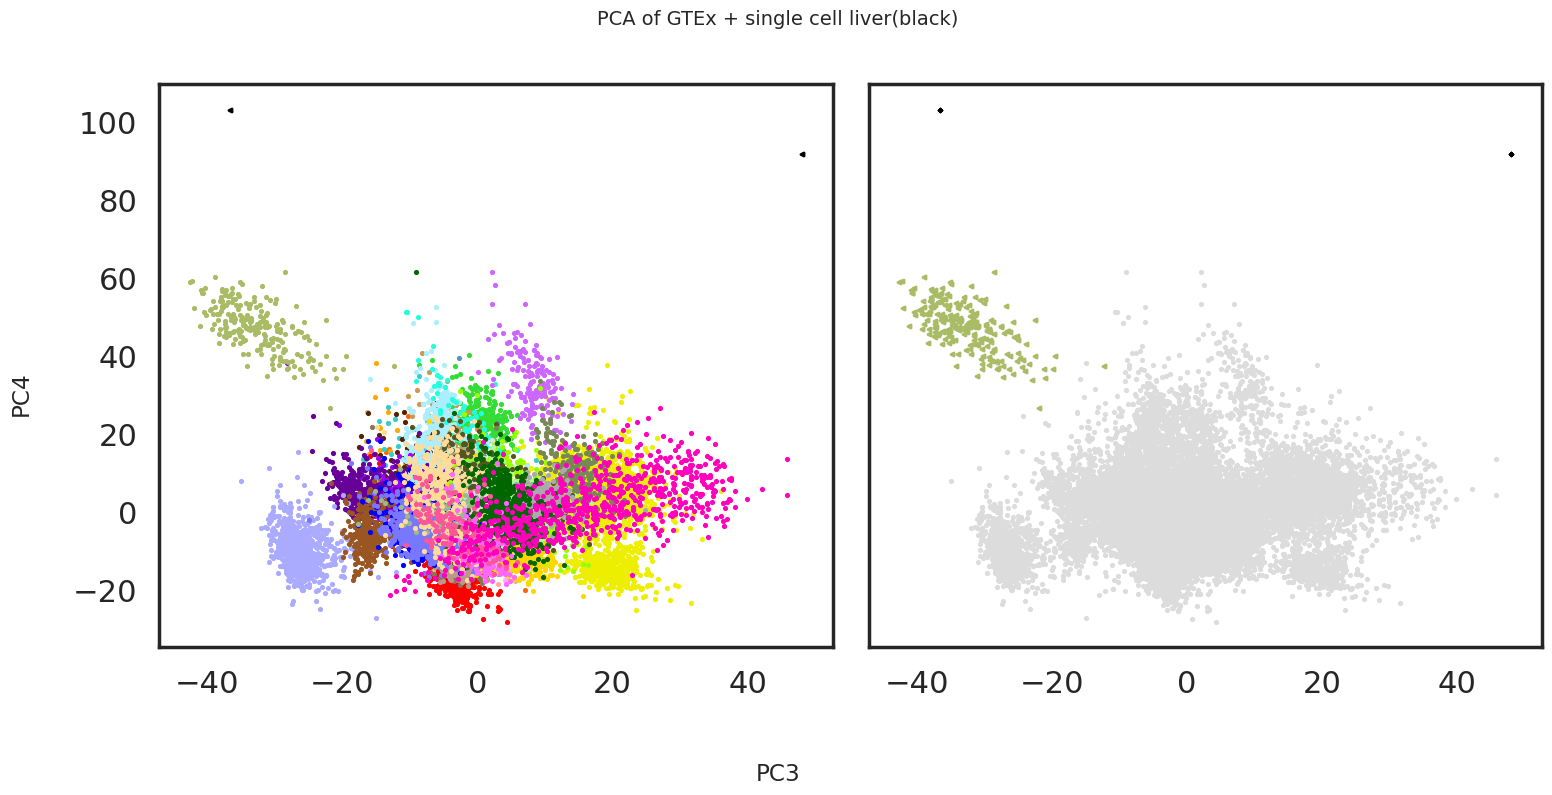

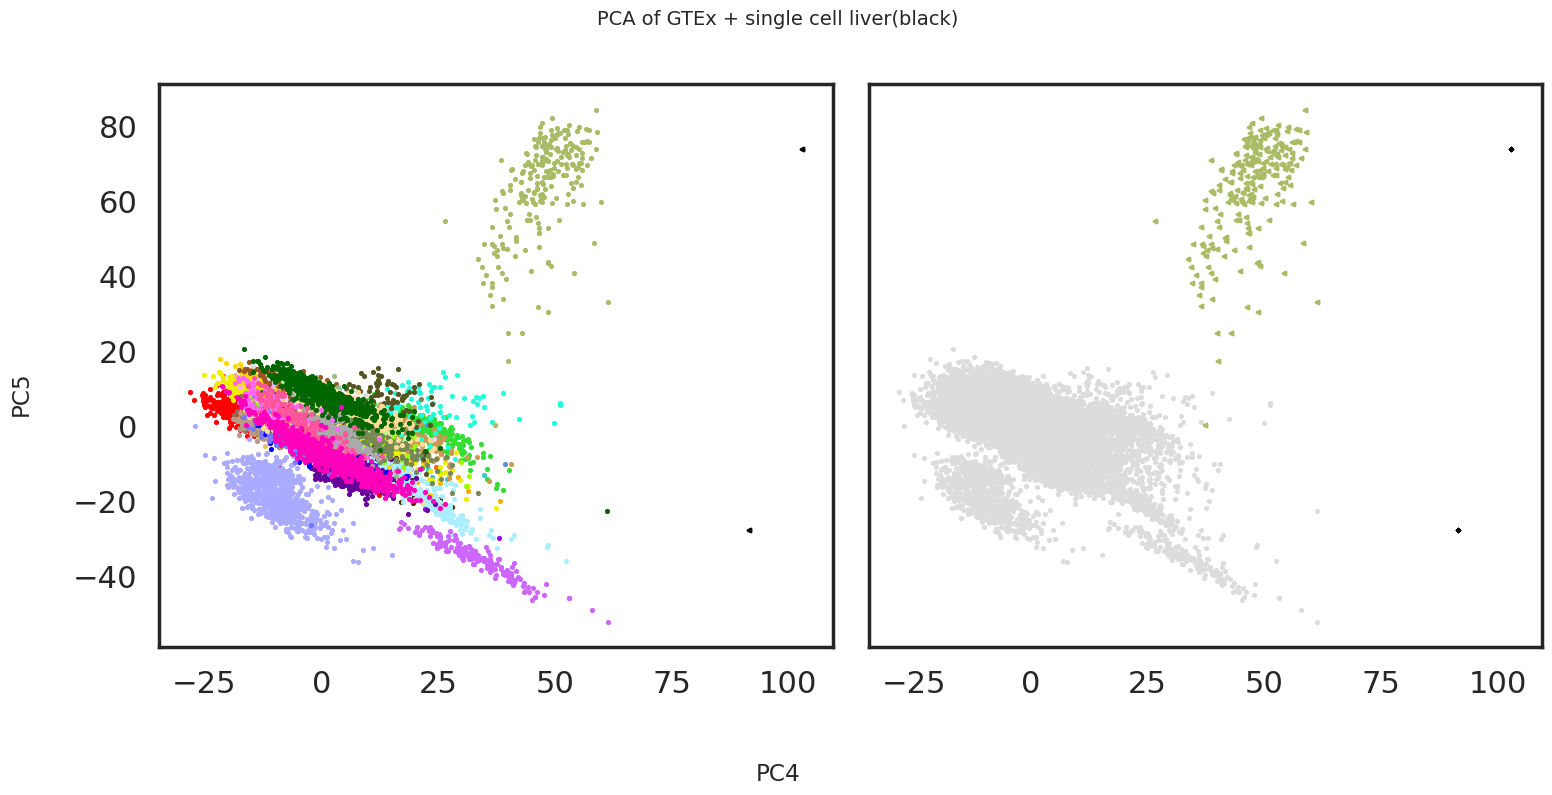

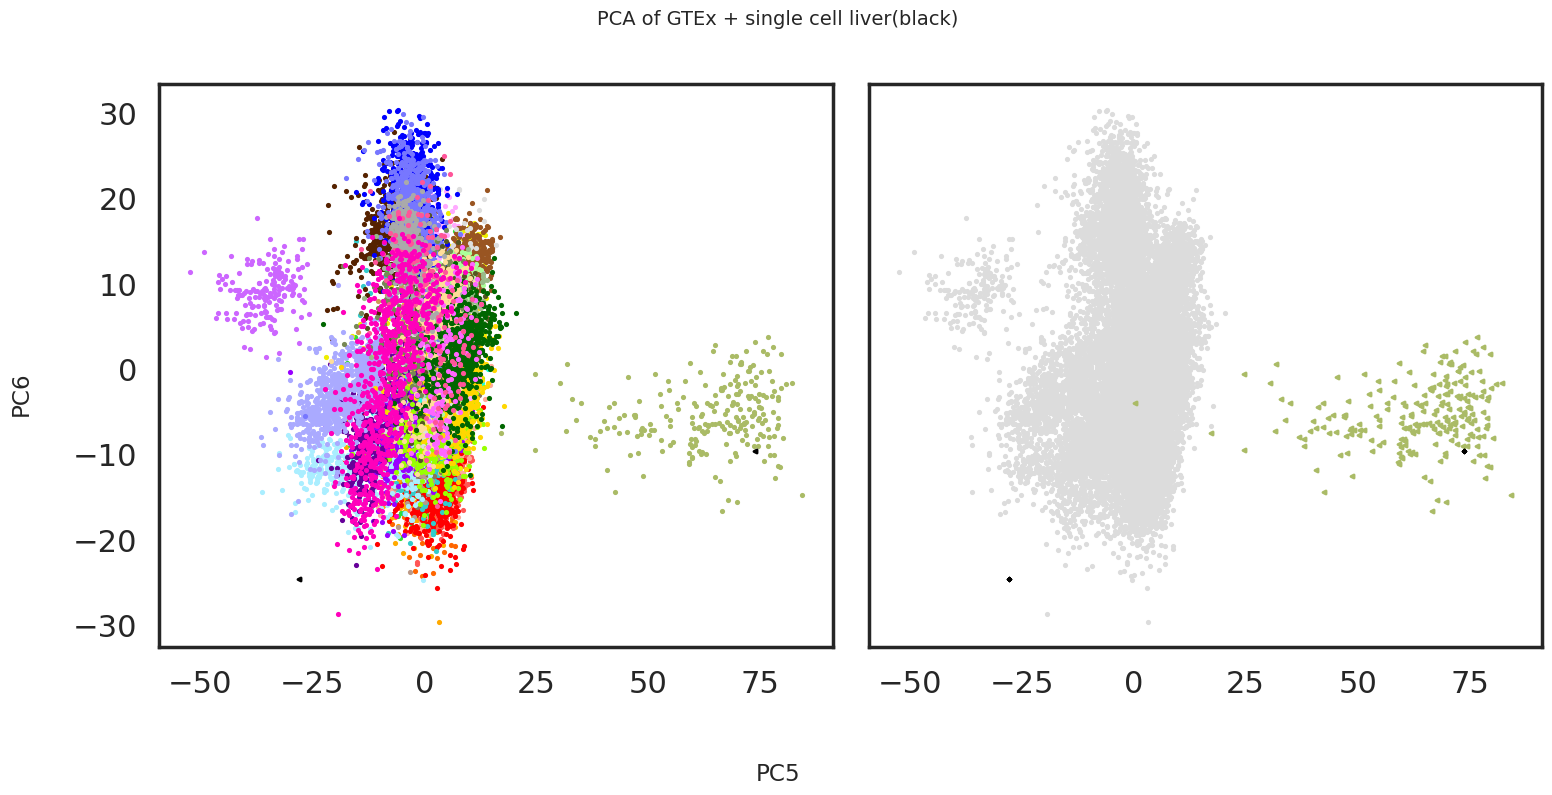

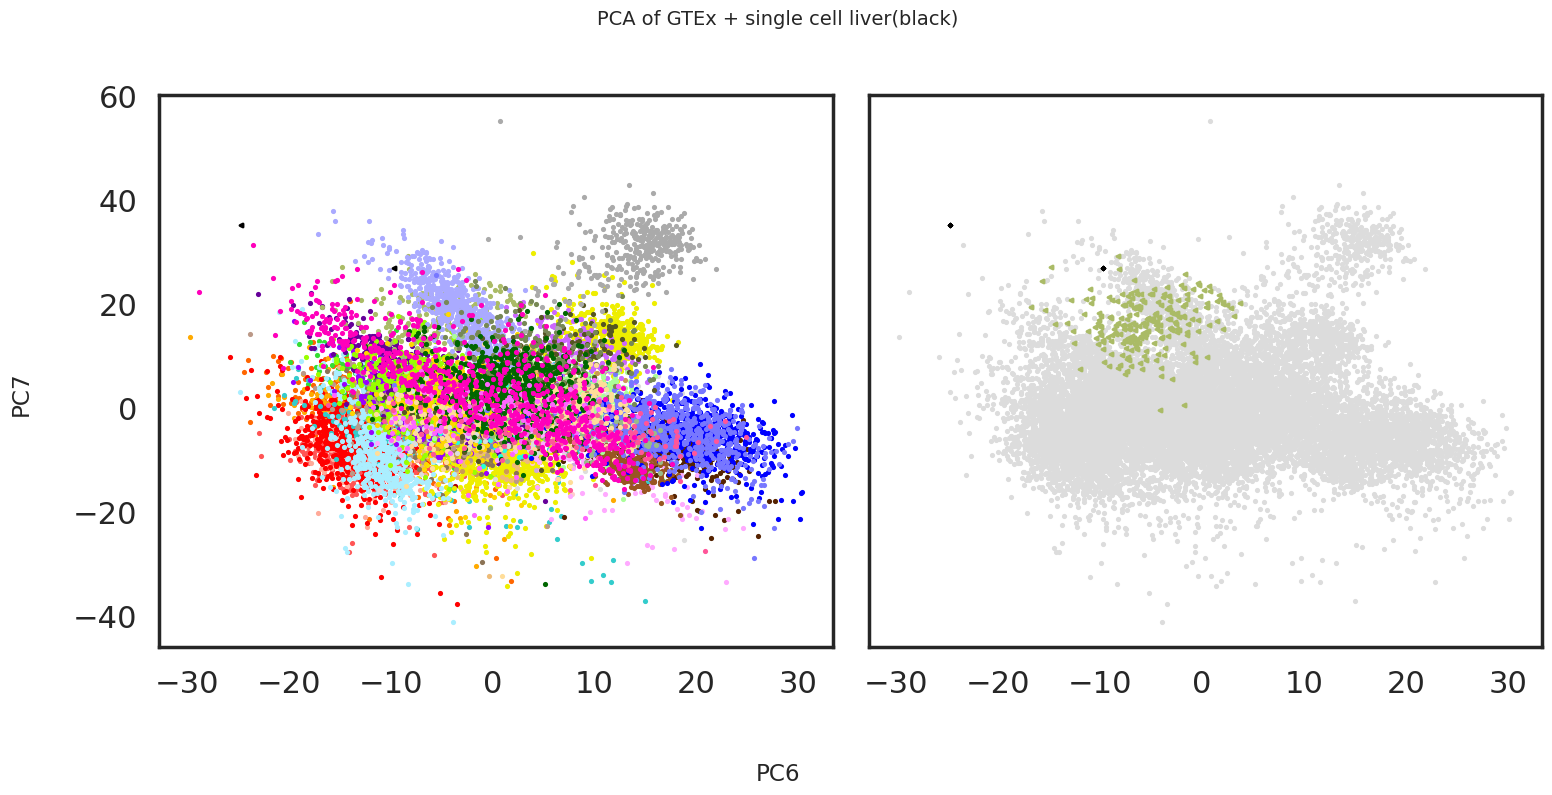

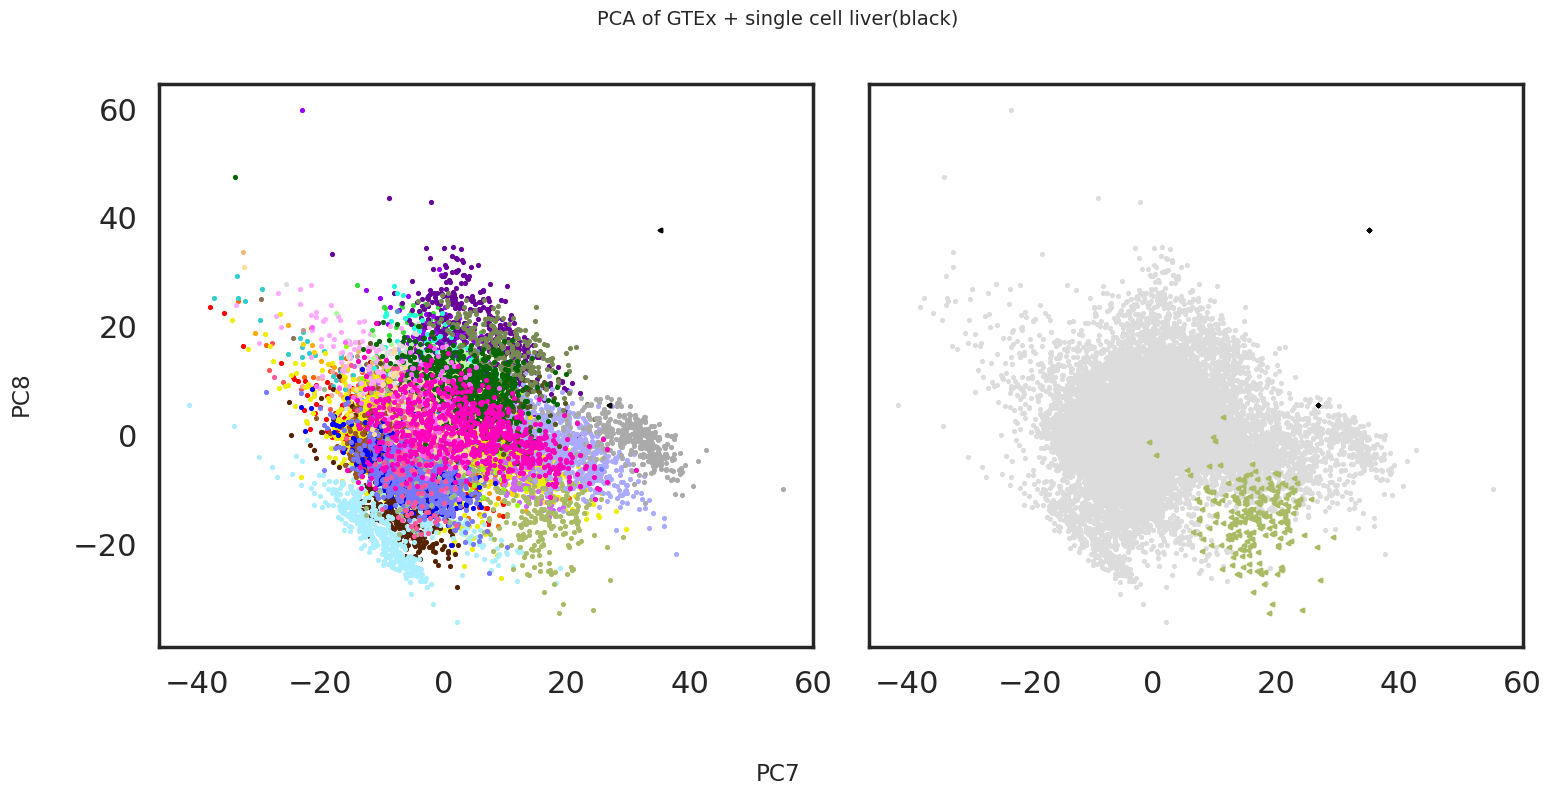

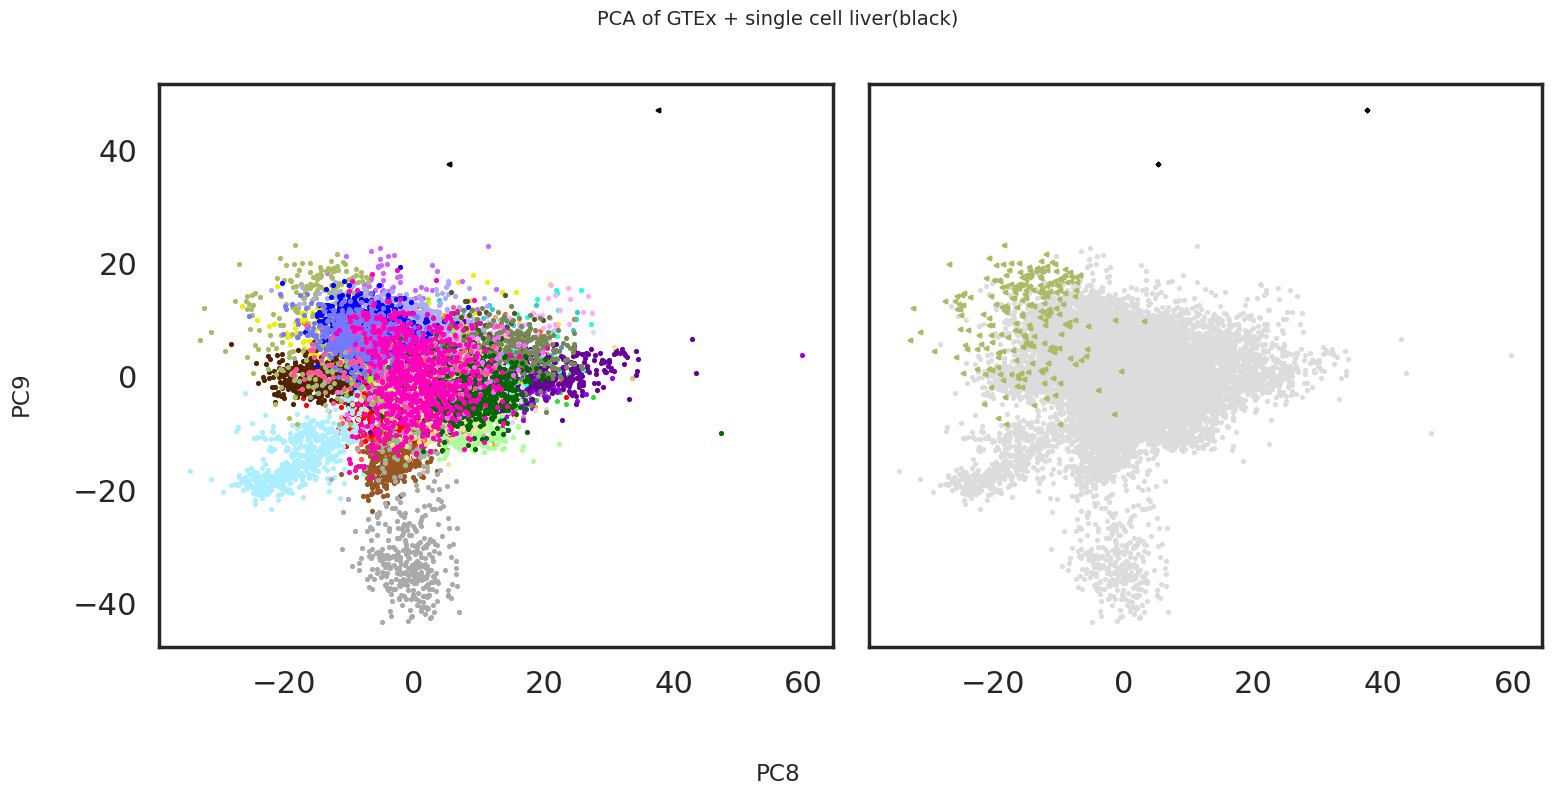

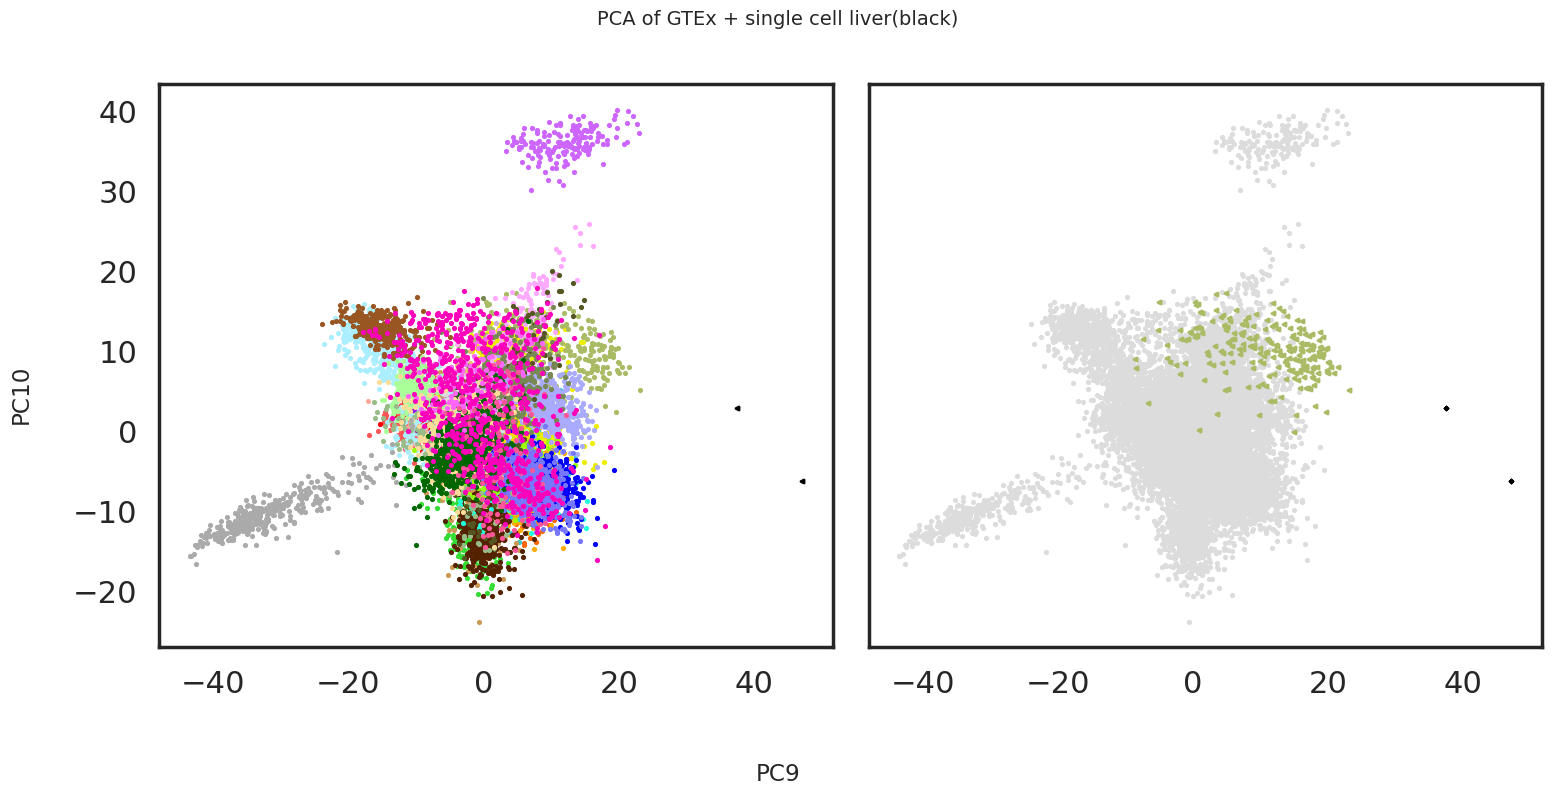

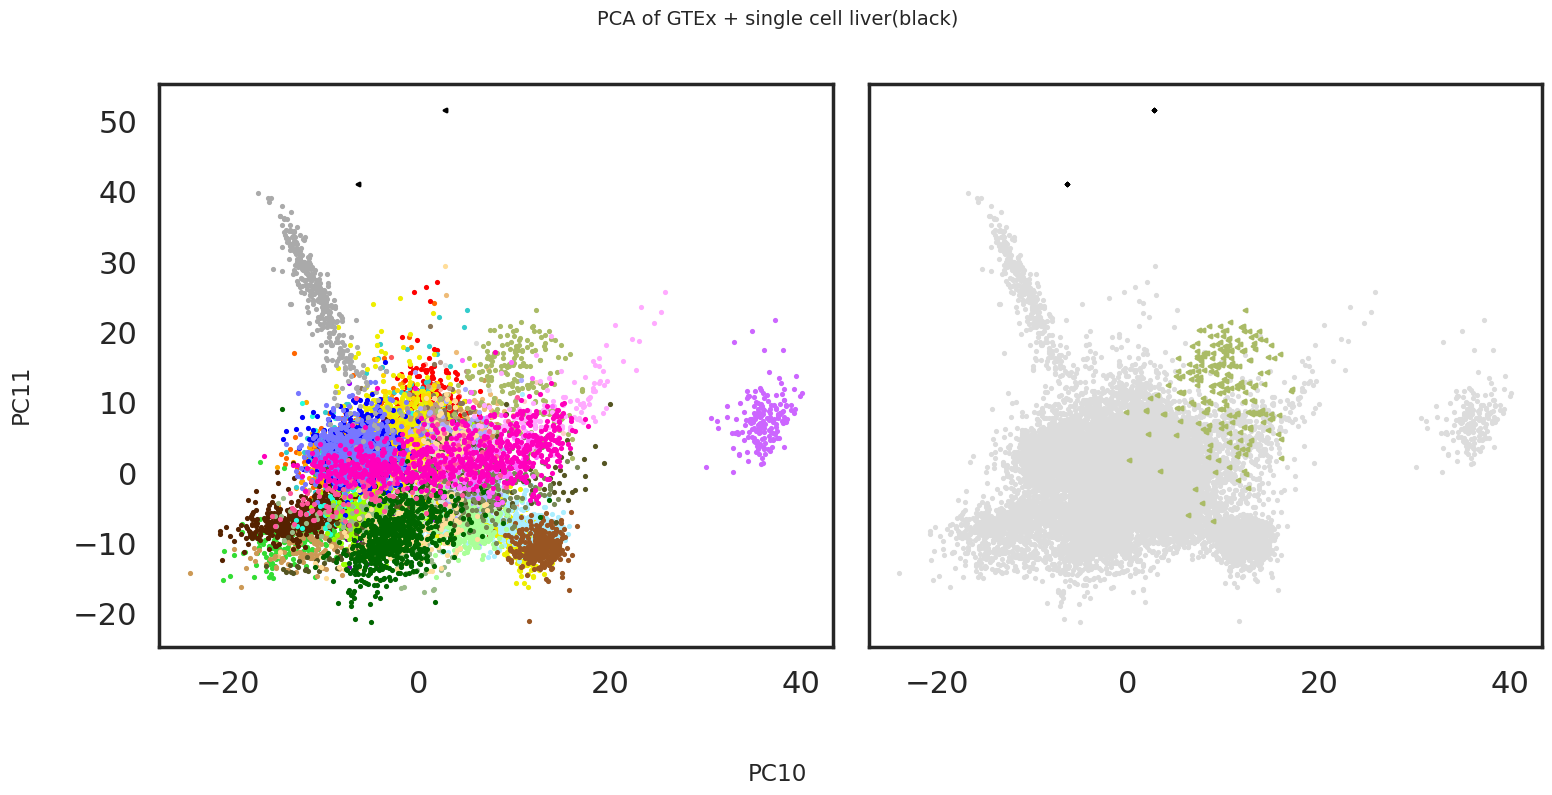

In [88]:
# make the plot of PCA result

for j in range(10):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

    scatter_x = np.array(ppc[:,j])
    scatter_y = np.array(ppc[:,j+1])
    group = np.array(merged_i.Tissue.tolist())
    cdict = {"Kidney - Medulla" : [89, 145, 203], "ADPSBQ":[255,102,0],"ADPVSC":[255,170,0],"ADRNLG":[51,221,51],"ARTAORT":[255,85,85],"ARTCRN":[255,170,153],"ARTTBL":[255,0,0],"BLDDER":[170,0,0],"BRNAMY":[238,238,0],"BRNACC":[238,238,0],"BRNCDT":[238,238,0],"BRNCHB":[238,238,0],"BRNCHA":[238,238,0],"BRNCTXA":[238,238,0],"BRNCTXB":[238,238,0],"BRNHPP":[238,238,0],"BRNHPT":[238,238,0],"BRNNCC":[238,238,0],"BRNPTM":[238,238,0],"BRNSPC":[238,238,0],"BRNSNG":[238,238,0],"BREAST":[51,204,204],"LCL":[204,102,255],"FIBRBLS":[170,238,255],"CVXECT":[255,204,204],"CVSEND":[204,170,221],"CLNSGM":[238,187,119],"CLNTRN":[204,153,85],"EESPGEJ":[139,115,85],"ESPMCS":[85,34,0],"ESPMSL":[187,153,136],"FLLPNT":[255,204,204],"HRTAA":[153,0,255],"HRTLV":[102,0,153],"KDNCTX":[34,255,221],"LIVER":[170,187,102],"LUNG":[153,255,0],"SLVRYG":[153,187,136],"MSCLSK":[170,170,255],"NERVET":[255,215,0],"OVARY":[255,170,255],"PNCREAS":[153, 85, 34],"PTTARY":[170,255,153],"PRSTTE":[221,221,221],"SKINNS":[0,0,255],"SKINS":[119,119,255],"SNTTRM":[85,85,34],"SPLEEN":[119,136,85],"STMACH":[255,221,153],"TESTIS":[170,170,170],"THYROID":[0,102,0],"UTERUS":[255,102,255],"VAGINA":[255,85,153],"WHLBLD":[255,0,187], "macrophage": [0,0,0], "monocyte":[0,0,0], "endothelial cell of hepatic sinusoid":[0,0,0], "liver dendritic cell":[0,0,0], "nk cell":[0,0,0], "fibroblast":[0,0,0], "hepatocyte":[0,0,0], "intrahepatic cholangiocyte":[0,0,0], "t cell":[0,0,0], "neutrophil":[0,0,0], "plasma cell":[0,0,0], "erythrocyte":[0,0,0], "endothelial cell":[0,0,0], "liver":[0, 0, 0]}


    for g in np.unique(group):
        if g != "liver":
            ix = np.where(group == g)
            ax[0].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, s = 3, zorder = 0)
        else:
            ix = np.where(group == g)
            ax[0].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, marker = "<", s = 5, zorder = 1)

    # ax[0].legend()




    for i in range(len(np.unique(group))):
        
        g = np.unique(group)[i]
        if (g!= "liver") and (g!= "LIVER"):
            ix = np.where(group == g)
            ax[1].scatter(scatter_x[ix], scatter_y[ix], color = np.array([220, 220, 220])/255.0, s = 3, zorder = 0)
        elif(g == "LIVER"):
            ix = np.where(group == g)
            ax[1].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, marker = "<", s = 5, zorder = 1)
        elif(g == "liver"):
            ix = np.where(group == g)
            ax[1].scatter(scatter_x[ix], scatter_y[ix], color = np.array(cdict[g])/255.0, marker = "x", s = 5, zorder = 1)

    # ax[1].legend()

    fig.supxlabel("PC{}".format(j+1), fontsize = 'x-small')
    fig.supylabel("PC{}".format(j+2), fontsize = 'x-small')
    # plt.legend(loc = 0, fontsize = 'xx-small')
    fig.suptitle('PCA of GTEx(GTEx liver: green) + single cell liver(black)', fontsize=14)
    

    #plt.savefig("Figures/Umap/TS_Liver_normalized_cta_1.jpg")
    plt.tight_layout()
    plt.show()
    